# Object Detection BaGi

## Import Libraries


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import Dataset

The Dataset we store at https://storage.googleapis.com/zurvin-bucket/dataset.tgz

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/zurvin-bucket/dataset.tgz"
data_dir = tf.keras.utils.get_file('dataset.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

8169794/8169794 [==============================] - 2s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1337


This is 4 class we used to train

Shirt

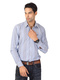

In [4]:
shirt = list(data_dir.glob('Shirt/*'))
PIL.Image.open(str(shirt[0]))

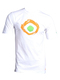

In [5]:
PIL.Image.open(str(shirt[1]))

Bag

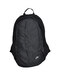

In [6]:
bag = list(data_dir.glob('Bag/*'))
PIL.Image.open(str(bag[0]))

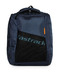

In [7]:
PIL.Image.open(str(bag[1]))

Shoe

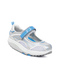

In [8]:
shoe = list(data_dir.glob('Shoe/*'))
PIL.Image.open(str(shoe[0]))

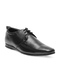

In [9]:
PIL.Image.open(str(shoe[1]))

Defected Samples

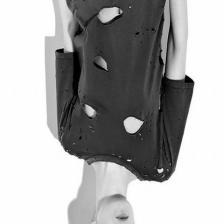

In [10]:
defect = list(data_dir.glob('Defected/*'))
PIL.Image.open(str(defect[0]))

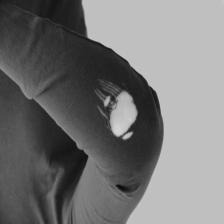

In [11]:
PIL.Image.open(str(defect[1]))

### Create dataset

In [12]:
batch_size = 16
img_height = 224
img_width = 224

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1337 files belonging to 4 classes.
Using 1070 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1337 files belonging to 4 classes.
Using 267 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['Bag', 'Defected', 'Shirt', 'Shoe']


## Here some Example

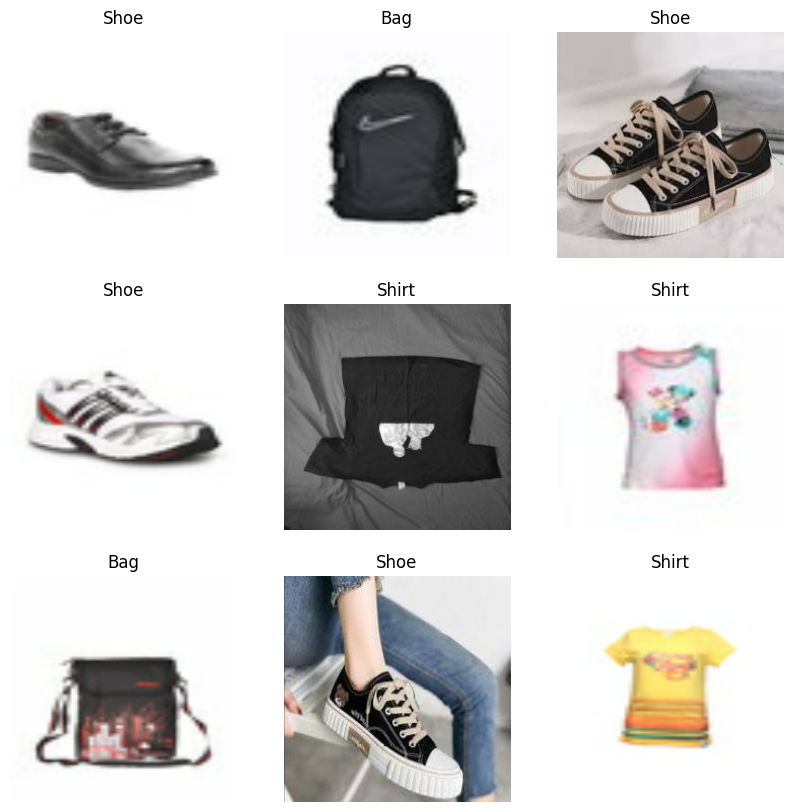

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize the data

In [19]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7725491


## Augmentation

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

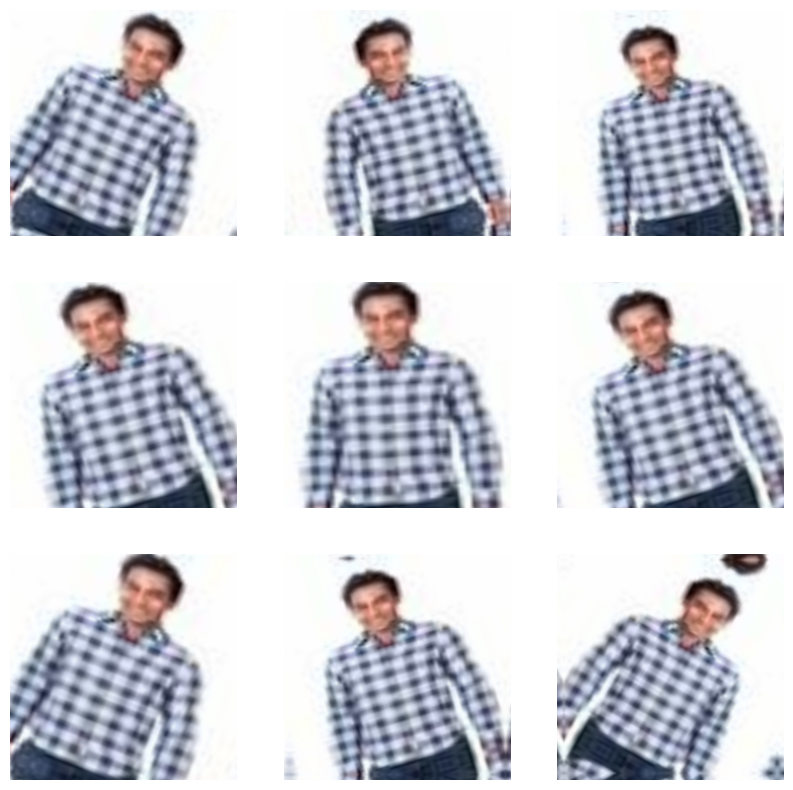

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create Model

In [38]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

In [41]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
67/67 [==============================] - 5s 29ms/step - loss: 1.5138 - accuracy: 0.4841 - val_loss: 0.8864 - val_accuracy: 0.7041
Epoch 2/100
67/67 [==============================] - 2s 25ms/step - loss: 0.7562 - accuracy: 0.7121 - val_loss: 0.6310 - val_accuracy: 0.7416
Epoch 3/100
67/67 [==============================] - 2s 26ms/step - loss: 0.6323 - accuracy: 0.7430 - val_loss: 0.5541 - val_accuracy: 0.7865
Epoch 4/100
67/67 [==============================] - 2s 26ms/step - loss: 0.5471 - accuracy: 0.8093 - val_loss: 0.4813 - val_accuracy: 0.8390
Epoch 5/100
67/67 [==============================] - 2s 26ms/step - loss: 0.5017 - accuracy: 0.8140 - val_loss: 0.4979 - val_accuracy: 0.8464
Epoch 6/100
67/67 [==============================] - 2s 27ms/step - loss: 0.4430 - accuracy: 0.8458 - val_loss: 0.4458 - val_accuracy: 0.8727
Epoch 7/100
67/67 [==============================] - 2s 28ms/step - loss: 0.4219 - accuracy: 0.8570 - val_loss: 0.5572 - val_accuracy: 0.7828
Epoch 

## Visualize the results


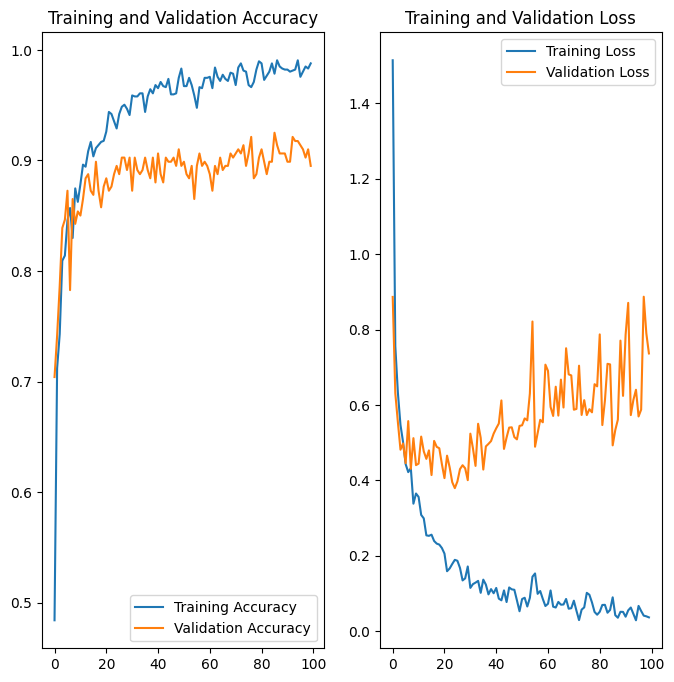

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Making Prediction

In [43]:
shirt_url = "https://image.uniqlo.com/UQ/ST3/AsianCommon/imagesgoods/422992/sub/goods_422992_sub14.jpg?width=494"
shirt_path = tf.keras.utils.get_file('1', origin=shirt_url)

img = tf.keras.utils.load_img(
    shirt_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 252ms/step
This image most likely belongs to Shirt with a 99.61 percent confidence.


### Convert Model to TFLite



In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)